In [1]:
# basics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time

# deep learning libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,ZeroPadding2D,Activation
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input

# magic functions
%matplotlib inline

2022-03-02 17:59:23.635686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 17:59:23.636183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# images full path
fits_full_path = './simulations/fits_files/'

# selected bandpasses
selected_bandpass = {
    'desg':'g',
    'desr':'r',
    'desi':'i'
}

# metadata files
metadata = pd.read_csv(fits_full_path+'metadata.txt')
metadata.dropna(inplace=True) # first line has Nan values and I still don't know why

# basic variables
num_pix = metadata['numPix-g'].iloc[-1] # same for all bandpasses
pixel_scale = metadata['pixel_scale-g'].iloc[-1] # same for all bandpasses
system_label = np.array(metadata['OBJID-g'])

In [3]:
# split our data in training and test dataset with ration 80 - 20 %
np.random.seed(42)
files_names_train, files_names_test = train_test_split(system_label, test_size=0.2)
print(len(files_names_train), len(files_names_test))

11999 3000


In [4]:
# split our data in training and validation dataset with ration 90 - 10 %
np.random.seed(42)
files_names_train, files_names_val = train_test_split(files_names_train, test_size=0.1)
print(len(files_names_train), len(files_names_val), len(files_names_test))

10799 1200 3000


In [5]:
# train dataset
x_train = []
y_train = []
for i in range(0, len(files_names_train)):
    x_train.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_train[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_train[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_train[i])+'.fits')[0].data]))
    
x_train = np.array(x_train)
y_train = np.array([np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'][files_names_train]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'][files_names_train]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_train])]).T


# validation dataset
x_val = []
y_val = []
for i in range(0, len(files_names_val)):
    x_val.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_val[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_val[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_val[i])+'.fits')[0].data]))
    
x_val = np.array(x_val)
y_val = np.array([np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'][files_names_val]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'][files_names_val]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_val])]).T

# validation dataset
x_test = []
y_test = []
for i in range(0, len(files_names_test)):
    x_test.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_test[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_test[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_test[i])+'.fits')[0].data]))
    
x_test = np.array(x_test)
y_test = np.array([np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'][files_names_test]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'][files_names_test]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_test])]).T


In [6]:
#np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_test])

In [7]:
x_train = np.moveaxis(x_train, 1, 2)
x_train = np.moveaxis(x_train, 3, 2)

x_test = np.moveaxis(x_test, 1, 2)
x_test = np.moveaxis(x_test, 3, 2)

x_val = np.moveaxis(x_val, 1, 2)
x_val = np.moveaxis(x_val, 3, 2)

print(x_train.shape, x_test.shape, x_val.shape)

(10799, 100, 100, 3) (3000, 100, 100, 3) (1200, 100, 100, 3)


In [8]:
# Our deep learning algorithm 
inputs = tf.keras.Input(shape=(100, 100, 3))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'mse'
)

gen = tf.keras.preprocessing.image.ImageDataGenerator()

batch_size=32
start = time.perf_counter()
generator = gen.flow(x_train, y_train, batch_size = batch_size)

history = model.fit_generator(
    generator,
    steps_per_epoch=len(x_train)/batch_size,
    epochs=30,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

)

2022-03-02 18:06:22.428134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 18:06:22.431054: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 18:06:22.431984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0SVSQGR): /proc/driver/nvidia/version does not exist
2022-03-02 18:06:22.436606: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_1387/1425935768.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed 

Epoch 1/30
337/337 [==============================] - 113s 316ms/step - loss: 0.7014 - val_loss: 0.0667
Epoch 2/30
337/337 [==============================] - 109s 323ms/step - loss: 0.0562 - val_loss: 0.0508
Epoch 3/30
337/337 [==============================] - 114s 339ms/step - loss: 0.0430 - val_loss: 0.0337
Epoch 4/30
337/337 [==============================] - 109s 324ms/step - loss: 0.0356 - val_loss: 0.0294
Epoch 5/30
337/337 [==============================] - 109s 324ms/step - loss: 0.0333 - val_loss: 0.0285
Epoch 6/30
337/337 [==============================] - 100s 298ms/step - loss: 0.0271 - val_loss: 0.0240
Epoch 7/30
337/337 [==============================] - 99s 293ms/step - loss: 0.0276 - val_loss: 0.0295
Epoch 8/30
337/337 [==============================] - 108s 321ms/step - loss: 0.0256 - val_loss: 0.0221
Epoch 9/30
337/337 [==============================] - 131s 387ms/step - loss: 0.0252 - val_loss: 0.0234
Epoch 10/30
337/337 [==============================] - 126s 375ms

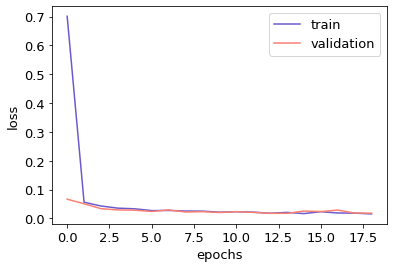

In [9]:
plt.rcParams.update({"font.size": 13})

plt.plot(history.history['loss'], label='train', c='slateblue')
plt.plot(history.history['val_loss'], label='validation', c='salmon')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [10]:
%%time
results = np.squeeze(model.predict(x_test)).T

2022-03-02 18:42:15.513962: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360000000 exceeds 10% of free system memory.


CPU times: user 32.9 s, sys: 3.92 s, total: 36.8 s
Wall time: 12.9 s


In [11]:
results = pd.DataFrame(np.array([files_names_test, results[0], y_test.T[0], results[1], y_test.T[1], results[2], y_test.T[2]]).T, columns=['sys', 'e1_pred', 'e1_true', 'e2_pred', 'e2_true', 'thetae_pred', 'thetae_true'])
results.head()

,sys,e1_pred,e1_true,e2_pred,e2_true,thetae_pred,thetae_true
0,6724.0,0.215755,0.128578,0.478072,0.357076,3.788190,3.810371
1,6474.0,0.551901,0.480868,0.065505,0.050779,3.777076,3.796621
2,4680.0,0.258740,0.242176,0.124762,0.121163,3.822264,3.958710
3,863.0,-0.142227,-0.200352,-0.000663,-0.003612,3.097307,3.111711
4,7287.0,0.287283,0.347171,-0.366844,-0.353522,3.288783,3.338077


In [12]:
# deep learning results to a txt
results.to_csv('./dl_results/DL_results.csv', index=False)

In [13]:
# save our model to a h5 file
model.save('./dl_results/dl_architecture.h5')

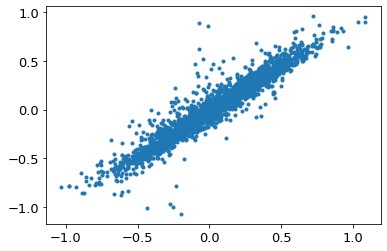

In [14]:
plt.plot(results['e1_pred'], results['e1_true'], '.')

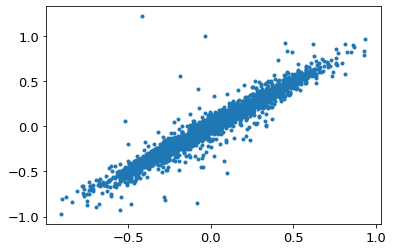

In [15]:
plt.plot(results['e2_pred'], results['e2_true'], '.')

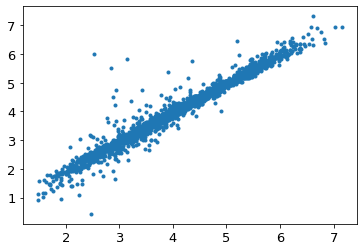

In [16]:
plt.plot(results['thetae_pred'], results['thetae_true'], '.')

In [17]:
model.save('./dl_results/my_dl_model')

2022-03-02 18:42:26.812240: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./dl_results/my_dl_model/assets


In [18]:
model.save_weights('./dl_results/weights')